In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_dir = '/content/drive/Shareddrives/Stat605_Project/data.zip'

import zipfile
zip_ref = zipfile.ZipFile(data_dir, 'r')
zip_ref.extractall('files')
zip_ref.close()

In [3]:
#import necessory libraries
import time
import os
import sys
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

> # **Exploring the Dataset**

In [6]:
train_dir = "/content/files/Train/Train"
valid_dir = "/content/files/Valid/Valid"

In [7]:
batch_size = 64

train_ds = ImageFolder(train_dir,transform = transforms.Compose([
    transforms.ToTensor()                    #transforms.Resize((256, 256)),
]))

train_dl = DataLoader(train_ds, batch_size, shuffle = False)

train_mean = []
train_std = []

for i, image in enumerate(train_dl, 0):
    numpy_image = image[0].numpy()

    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))

    train_mean.append(batch_mean)
    train_std.append(batch_std)

train_mean = torch.tensor(np.mean(train_mean, axis=0))
train_std = torch.tensor(np.mean(train_std, axis=0))

In [8]:
print('Mean:', train_mean)
print('Std Dev:', train_std)

Mean: tensor([0.5244, 0.5091, 0.4340])
Std Dev: tensor([0.2765, 0.2704, 0.2847])


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(train_mean, train_std)
    ]),
}

train_ds = ImageFolder(train_dir,transform = data_transforms['train'])
train_dl = DataLoader(dataset=train_ds,
                      batch_size=batch_size,
                      shuffle=True)

val_ds = ImageFolder(valid_dir, transform = data_transforms['train'])
val_dl = DataLoader(val_ds, batch_size, shuffle = True)

The images are rgb and have 256*256 pixel in each image

In [10]:
print(f"Images in tarining data : {len(train_ds)}")
print(f"Images in test data : {len(val_ds)}")

Images in tarining data : 30000
Images in test data : 2000


In [11]:
classes = train_ds.classes
num_classes = len(train_ds.classes)
print("Follwing classes are there : \n", train_ds.classes)

Follwing classes are there : 
 ['Beetle', 'Butterfly', 'Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Lizard', 'Monkey', 'Mouse', 'Panda', 'Spider', 'Tiger', 'Zebra']


In [12]:
def display_img(img,label):
    print(f"Label : {train_ds.classes[label]}")
    plt.imshow(img.permute(1,2,0))

> # Visualising some images :

Label : Panda


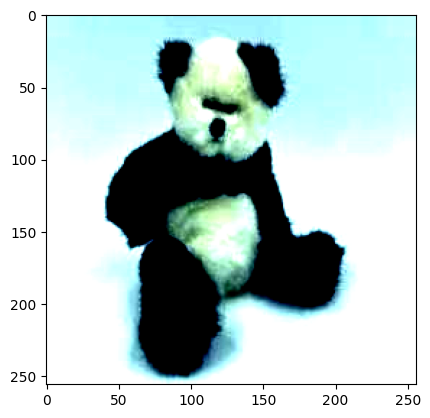

In [13]:
display_img(*train_ds[23100])

> # Model Setting:

In [19]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.005
NUM_EPOCHS = 1

# Architecture
NUM_FEATURES = 256*256
NUM_CLASSES = len(train_ds.classes)
print(f'We have {NUM_CLASSES} classes.')


# Other
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"

GRAYSCALE = False

device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_dl):

        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])

        x = x.to(device)
        y = y.to(device)
        break

We have 15 classes.
Epoch: 1 | Batch index: 0 | Batch size: 64
Epoch: 2 | Batch index: 0 | Batch size: 64


> # **Grid Of Train Data Images :**

In [15]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

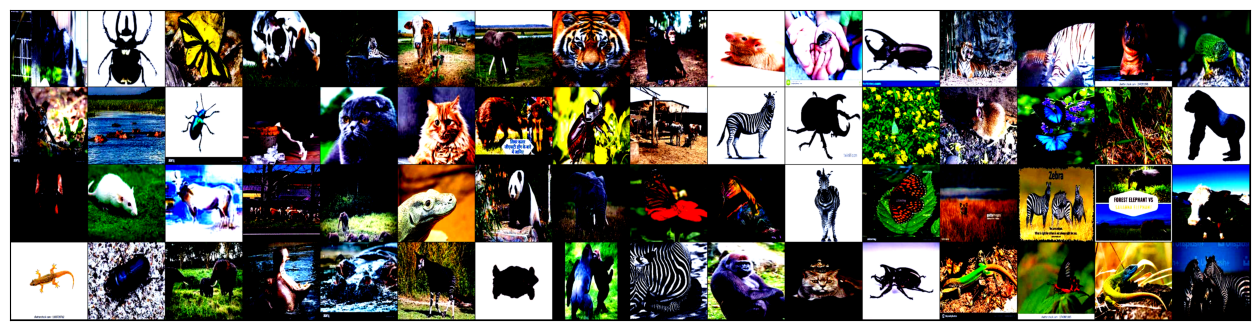

In [16]:
show_batch(train_dl)

> # Model

In [17]:
class LeNet5(nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super(LeNet5, self).__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = nn.Sequential(

            nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(178608, 120*in_channels),
            nn.Tanh(),
            nn.Linear(120*in_channels, 84*in_channels),
            nn.Tanh(),
            nn.Linear(84*in_channels, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [54]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model = model.to(DEVICE)
print(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

cuda:0


In [24]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):

        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        cross_entropy += F.cross_entropy(logits, targets).item()
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100, cross_entropy/num_examples

In [56]:
start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(1): #NUM_EPOCHS):

    model.train()

    for batch_idx, (features, targets) in enumerate(train_dl):

        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 500:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_dl):03d} |'
                   f' Cost: {cost:.4f}')

    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss = compute_accuracy_and_loss(model, train_dl, device=DEVICE)
        valid_acc, valid_loss = compute_accuracy_and_loss(model, val_dl, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')

elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

Epoch: 001/010 | Batch 000/469 | Cost: 2.3718
Epoch: 001/010 Train Acc.: 17.34% | Validation Acc.: 17.45%
Time elapsed: 2.83 min
Total Training Time: 2.83 min




> # Evaluate



In [57]:
print(train_loss_lst, valid_loss_lst)

[0.03976516308784485] [0.04101028203964233]


In [ ]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()



> # Test Evaluation


In [58]:
########### Test Eval

test_dir = '/content/files/Test'
test_ds = ImageFolder(test_dir, transform=data_transforms['valid'])
test_dl = DataLoader(test_ds, batch_size, shuffle = True)

model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_dl, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 19.94%


In [33]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


unorm = UnNormalize(mean=train_mean, std=train_std)

In [53]:
d = {}
for i in range(NUM_CLASSES):
    d[i] = train_ds.classes[i]

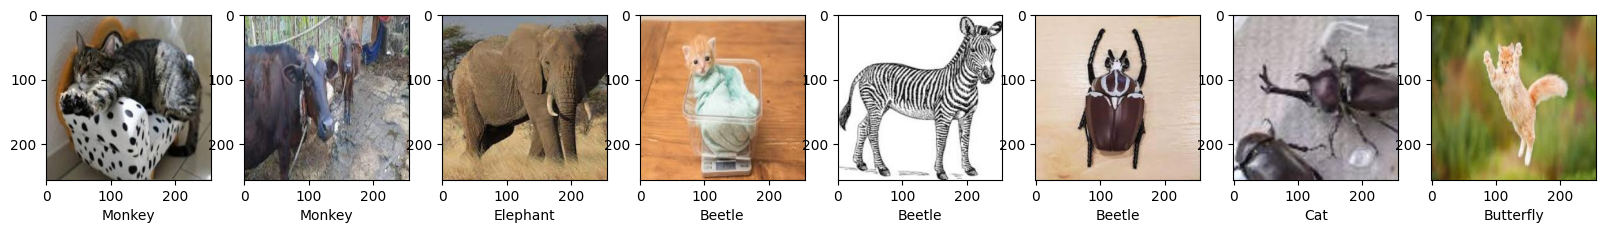

In [59]:

_, predictions = model.forward(features[:8].to(DEVICE))
predictions = torch.argmax(predictions, dim=1)


fig, ax = plt.subplots(1, 8, figsize=(20, 10))
for i in range(8):
    img = unorm(features[i])
    ax[i].imshow(img.cpu().permute(1,2,0))
    ax[i].set_xlabel(d[predictions[i].item()])

plt.show()